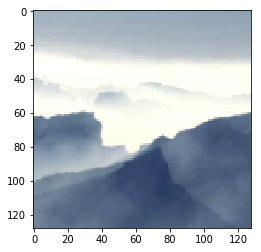

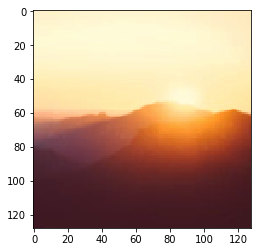

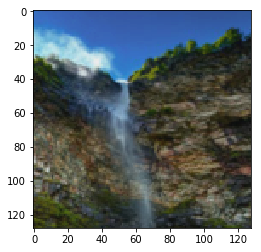

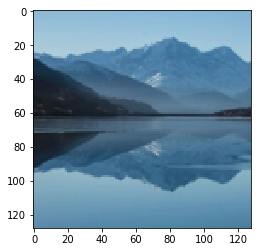

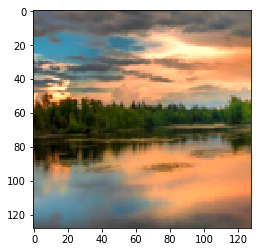

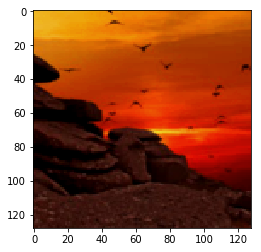

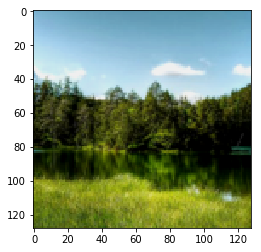

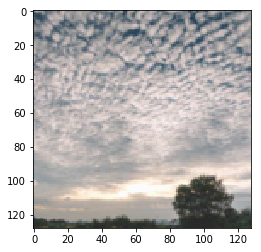

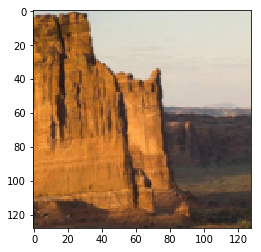

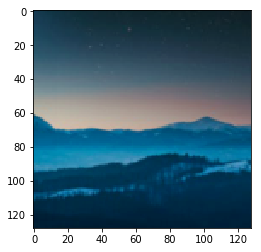

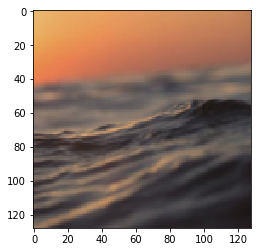

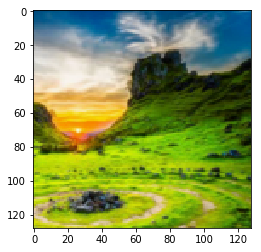

In [1]:
%matplotlib inline

import torch as th
import torchvision
import matplotlib.pyplot as plt
import Dataloader
import os

# select the device to be used for training
device = th.device("cuda" if th.cuda.is_available() else "cpu")

transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(3),
    torchvision.transforms.RandomCrop((256, 256)), # TODO: Random scale too
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(.2, .2, .1, .01),
    torchvision.transforms.ToTensor(),
  ])

dataset_dir = os.environ['DATASET_DIR']
dataset = Dataloader.FlatDirectoryImageDataset(dataset_dir + '/pexels/landscapes', transform=transforms)

for i, d in enumerate(dataset):
    plt.imshow(d.permute(1, 2, 0).numpy())
    plt.show()
    if i > 10:
         break



In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms

vgg = models.vgg13_bn(pretrained=True).to(device)

# freeze all model parameters
vgg.eval()
for param in vgg.parameters():
    param.requires_grad = False


def extract_features(x):
  # x = normalize(x)  # TODO
  #print(x.min(), x.max())
  
  # This is an approximation of the transform that the torchvision models want.
  x = (x - .5) * .6

  for i in range(12):
    x = vgg.features[i](x)
  return x

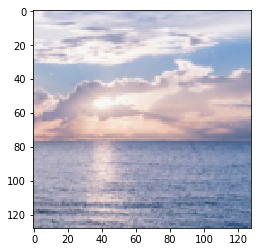

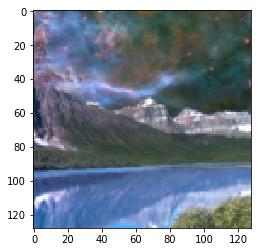

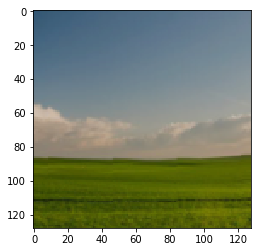

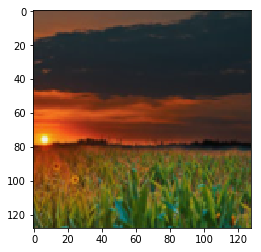

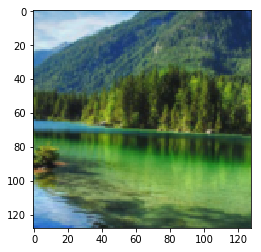

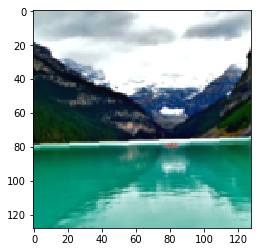

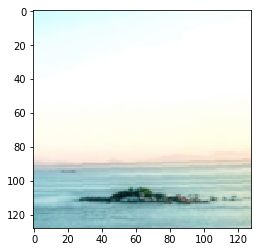

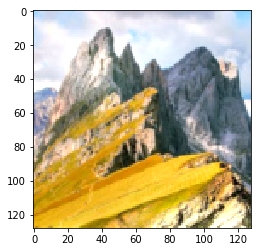

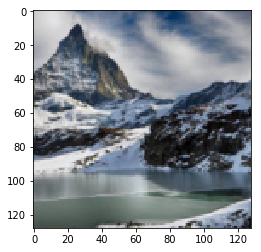

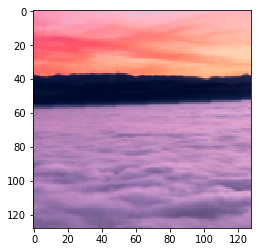

In [3]:
batch_size = 64

dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

anchor_targets = next(iter(dataloader)).to(device)
for i in range(10):
    plt.imshow(anchor_targets[i].permute(1, 2, 0).cpu().numpy())
    plt.show()


In [4]:
def create_grid(samples, img_file, scale_factor=1):
    """
    utility function to create a grid of GAN samples
    :param samples: generated samples for storing
    :param scale_factor: factor for upscaling the image
    :param img_file: name of file to write
    :return: None (saves a file)
    """
    from torchvision.utils import save_image
    from torch.nn.functional import interpolate

    # upsample the image
    if scale_factor > 1:
        samples = interpolate(samples, scale_factor=scale_factor)

    # save the images:
    save_image(samples, img_file, nrow=int(np.sqrt(len(samples))), normalize=True)

In [5]:
import PRO_GAN
import torch

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import cv2

latent_size = 128

g = PRO_GAN.Generator(depth=7, latent_size=latent_size).to(device)

anchor_latent_vectors = torch.randn(batch_size, latent_size, requires_grad=True, device=device)

anchor_optimizer = torch.optim.Adam(list(g.parameters()) + [anchor_latent_vectors], lr=.001)

anchor_targets = anchor_targets.to(device)

def optimize_generator_with_anchors():
    generated = g(anchor_latent_vectors, 5, 0)
    assert anchor_targets.shape == generated.shape, "generated shape %s does not match target shape %s" % (str(generated.shape), str(target.shape))
    loss = torch.mean(torch.abs(anchor_targets - generated))
    perceptual_loss = torch.mean(torch.abs(extract_features(anchor_targets) - extract_features(generated)))
    
    anchor_optimizer.zero_grad()
    loss.backward()
    anchor_optimizer.step()
    
    return loss.item()


In [6]:
"""for i in tqdm(range(100)):
    loss, generated = optimize_generator_with_anchors()
    
    filename = 'samples/%d.png' % i
    create_grid(generated, filename)
    if i % 100 == 0:
        print(loss)
        plt.imshow(cv2.imread(filename))
        plt.show()"""

"for i in tqdm(range(100)):\n    loss, generated = optimize_generator_with_anchors()\n    \n    filename = 'samples/%d.png' % i\n    create_grid(generated, filename)\n    if i % 100 == 0:\n        print(loss)\n        plt.imshow(cv2.imread(filename))\n        plt.show()"

In [ ]:
import Losses

d = PRO_GAN.Discriminator(7, latent_size).to(device)

disc_optim = torch.optim.Adam(d.parameters())
wgan_gp = Losses.WGAN_GP(d, use_gp=True)

def optimize_discriminator():
    real_samples = next(iter(dataloader)).to(device)
    
    noise = torch.randn(batch_size, latent_size, device=device)
    fake_samples = g(noise, 5, 0).detach()

    loss = wgan_gp.dis_loss(real_samples, fake_samples, 5, 0)

    disc_optim.zero_grad()
    loss.backward()
    disc_optim.step()
    
    return loss.item()

for i in range(5):
    print(optimize_discriminator())
    

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


8.525167465209961
7.822373390197754
6.929728984832764
5.900304794311523
4.421128273010254


  0%|          | 0/1000 [00:00<?, ?it/s]

0


/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


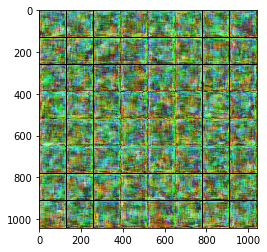

  0%|          | 1/1000 [00:00<15:24,  1.08it/s]

1


  0%|          | 2/1000 [00:01<13:58,  1.19it/s]

2


  0%|          | 3/1000 [00:02<13:30,  1.23it/s]

3


  0%|          | 4/1000 [00:03<13:17,  1.25it/s]

4


  0%|          | 5/1000 [00:03<13:08,  1.26it/s]

5


  1%|          | 6/1000 [00:04<13:01,  1.27it/s]

6


  1%|          | 7/1000 [00:05<12:55,  1.28it/s]

7


  1%|          | 8/1000 [00:06<12:51,  1.29it/s]

8


  1%|          | 9/1000 [00:06<12:47,  1.29it/s]

9


  1%|          | 10/1000 [00:07<12:43,  1.30it/s]

10


  1%|          | 11/1000 [00:08<12:39,  1.30it/s]

11


  1%|          | 12/1000 [00:09<12:36,  1.31it/s]

12


  1%|▏         | 13/1000 [00:09<12:33,  1.31it/s]

13


  1%|▏         | 14/1000 [00:10<12:30,  1.31it/s]

14


  2%|▏         | 15/1000 [00:11<12:27,  1.32it/s]

15


  2%|▏         | 16/1000 [00:12<12:24,  1.32it/s]

16


  2%|▏         | 17/1000 [00:12<12:22,  1.32it/s]

17


  2%|▏         | 18/1000 [00:13<12:19,  1.33it/s]

18


  2%|▏         | 19/1000 [00:14<12:17,  1.33it/s]

19


  2%|▏         | 20/1000 [00:15<12:15,  1.33it/s]

20


  2%|▏         | 21/1000 [00:15<12:14,  1.33it/s]

21


  2%|▏         | 22/1000 [00:16<12:12,  1.34it/s]

22


  2%|▏         | 23/1000 [00:17<12:11,  1.34it/s]

23


  2%|▏         | 24/1000 [00:17<12:09,  1.34it/s]

24


  2%|▎         | 25/1000 [00:18<12:08,  1.34it/s]

25


  3%|▎         | 26/1000 [00:19<12:07,  1.34it/s]

26


  3%|▎         | 27/1000 [00:20<12:06,  1.34it/s]

27


  3%|▎         | 28/1000 [00:20<12:05,  1.34it/s]

28


  3%|▎         | 29/1000 [00:21<12:04,  1.34it/s]

29


  3%|▎         | 30/1000 [00:22<12:04,  1.34it/s]

30


  3%|▎         | 31/1000 [00:23<12:03,  1.34it/s]

31


  3%|▎         | 32/1000 [00:23<12:03,  1.34it/s]

32


  3%|▎         | 33/1000 [00:24<12:02,  1.34it/s]

33


  3%|▎         | 34/1000 [00:25<12:01,  1.34it/s]

34


  4%|▎         | 35/1000 [00:26<12:01,  1.34it/s]

35


  4%|▎         | 36/1000 [00:26<12:00,  1.34it/s]

36


  4%|▎         | 37/1000 [00:27<11:59,  1.34it/s]

37


  4%|▍         | 38/1000 [00:28<11:59,  1.34it/s]

38


  4%|▍         | 39/1000 [00:29<11:58,  1.34it/s]

39


  4%|▍         | 40/1000 [00:29<11:57,  1.34it/s]

40


  4%|▍         | 41/1000 [00:30<11:57,  1.34it/s]

41


  4%|▍         | 42/1000 [00:31<11:56,  1.34it/s]

42


  4%|▍         | 43/1000 [00:32<11:55,  1.34it/s]

43


  4%|▍         | 44/1000 [00:32<11:54,  1.34it/s]

44


  4%|▍         | 45/1000 [00:33<11:54,  1.34it/s]

45


  5%|▍         | 46/1000 [00:34<11:53,  1.34it/s]

46


  5%|▍         | 47/1000 [00:35<11:52,  1.34it/s]

47


  5%|▍         | 48/1000 [00:35<11:51,  1.34it/s]

48


  5%|▍         | 49/1000 [00:36<11:50,  1.34it/s]

49


  5%|▌         | 50/1000 [00:37<11:49,  1.34it/s]

50


  5%|▌         | 51/1000 [00:38<11:48,  1.34it/s]

51


  5%|▌         | 52/1000 [00:38<11:47,  1.34it/s]

52


  5%|▌         | 53/1000 [00:39<11:47,  1.34it/s]

53


  5%|▌         | 54/1000 [00:40<11:46,  1.34it/s]

54


  6%|▌         | 55/1000 [00:41<11:45,  1.34it/s]

55


  6%|▌         | 56/1000 [00:41<11:44,  1.34it/s]

56


  6%|▌         | 57/1000 [00:42<11:43,  1.34it/s]

57


  6%|▌         | 58/1000 [00:43<11:42,  1.34it/s]

58


  6%|▌         | 59/1000 [00:43<11:41,  1.34it/s]

59


  6%|▌         | 60/1000 [00:44<11:40,  1.34it/s]

60


  6%|▌         | 61/1000 [00:45<11:39,  1.34it/s]

61


  6%|▌         | 62/1000 [00:46<11:38,  1.34it/s]

62


  6%|▋         | 63/1000 [00:46<11:37,  1.34it/s]

63


  6%|▋         | 64/1000 [00:47<11:36,  1.34it/s]

64


  6%|▋         | 65/1000 [00:48<11:34,  1.35it/s]

65


  7%|▋         | 66/1000 [00:49<11:33,  1.35it/s]

66


  7%|▋         | 67/1000 [00:49<11:32,  1.35it/s]

67


  7%|▋         | 68/1000 [00:50<11:31,  1.35it/s]

68


  7%|▋         | 69/1000 [00:51<11:30,  1.35it/s]

69


  7%|▋         | 70/1000 [00:51<11:29,  1.35it/s]

70


  7%|▋         | 71/1000 [00:52<11:28,  1.35it/s]

71


  7%|▋         | 72/1000 [00:53<11:27,  1.35it/s]

72


  7%|▋         | 73/1000 [00:54<11:26,  1.35it/s]

73


  7%|▋         | 74/1000 [00:54<11:25,  1.35it/s]

74


  8%|▊         | 75/1000 [00:55<11:24,  1.35it/s]

75


  8%|▊         | 76/1000 [00:56<11:23,  1.35it/s]

76


  8%|▊         | 77/1000 [00:56<11:22,  1.35it/s]

77


  8%|▊         | 78/1000 [00:57<11:20,  1.35it/s]

78


  8%|▊         | 79/1000 [00:58<11:19,  1.35it/s]

79


  8%|▊         | 80/1000 [00:59<11:18,  1.36it/s]

80


  8%|▊         | 81/1000 [00:59<11:17,  1.36it/s]

81


  8%|▊         | 82/1000 [01:00<11:16,  1.36it/s]

82


  8%|▊         | 83/1000 [01:01<11:15,  1.36it/s]

83


  8%|▊         | 84/1000 [01:01<11:14,  1.36it/s]

84


  8%|▊         | 85/1000 [01:02<11:13,  1.36it/s]

85


  9%|▊         | 86/1000 [01:03<11:12,  1.36it/s]

86


  9%|▊         | 87/1000 [01:03<11:11,  1.36it/s]

87


  9%|▉         | 88/1000 [01:04<11:10,  1.36it/s]

88


  9%|▉         | 89/1000 [01:05<11:08,  1.36it/s]

89


  9%|▉         | 90/1000 [01:06<11:07,  1.36it/s]

90


  9%|▉         | 91/1000 [01:06<11:06,  1.36it/s]

91


  9%|▉         | 92/1000 [01:07<11:05,  1.36it/s]

92


  9%|▉         | 93/1000 [01:08<11:04,  1.36it/s]

93


  9%|▉         | 94/1000 [01:08<11:03,  1.37it/s]

94


 10%|▉         | 95/1000 [01:09<11:02,  1.37it/s]

95


 10%|▉         | 96/1000 [01:10<11:01,  1.37it/s]

96


 10%|▉         | 97/1000 [01:10<11:00,  1.37it/s]

97


 10%|▉         | 98/1000 [01:11<10:59,  1.37it/s]

98


 10%|▉         | 99/1000 [01:12<10:58,  1.37it/s]

99


 10%|█         | 100/1000 [01:13<10:57,  1.37it/s]

100


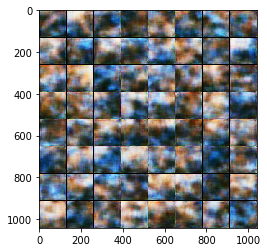

 10%|█         | 101/1000 [01:13<10:57,  1.37it/s]

101


 10%|█         | 102/1000 [01:14<10:56,  1.37it/s]

102


 10%|█         | 103/1000 [01:15<10:55,  1.37it/s]

103


 10%|█         | 104/1000 [01:15<10:54,  1.37it/s]

104


 10%|█         | 105/1000 [01:16<10:53,  1.37it/s]

105


 11%|█         | 106/1000 [01:17<10:52,  1.37it/s]

106


 11%|█         | 107/1000 [01:18<10:51,  1.37it/s]

107


 11%|█         | 108/1000 [01:18<10:50,  1.37it/s]

108


 11%|█         | 109/1000 [01:19<10:49,  1.37it/s]

109


 11%|█         | 110/1000 [01:20<10:48,  1.37it/s]

110


 11%|█         | 111/1000 [01:20<10:47,  1.37it/s]

111


 11%|█         | 112/1000 [01:21<10:46,  1.37it/s]

112


 11%|█▏        | 113/1000 [01:22<10:45,  1.37it/s]

113


 11%|█▏        | 114/1000 [01:22<10:44,  1.38it/s]

114


 12%|█▏        | 115/1000 [01:23<10:43,  1.38it/s]

115


 12%|█▏        | 116/1000 [01:24<10:42,  1.38it/s]

116


 12%|█▏        | 117/1000 [01:24<10:41,  1.38it/s]

117


 12%|█▏        | 118/1000 [01:25<10:40,  1.38it/s]

118


 12%|█▏        | 119/1000 [01:26<10:39,  1.38it/s]

119


 12%|█▏        | 120/1000 [01:27<10:38,  1.38it/s]

120


 12%|█▏        | 121/1000 [01:27<10:37,  1.38it/s]

121


 12%|█▏        | 122/1000 [01:28<10:36,  1.38it/s]

122


 12%|█▏        | 123/1000 [01:29<10:35,  1.38it/s]

123


 12%|█▏        | 124/1000 [01:29<10:34,  1.38it/s]

124


 12%|█▎        | 125/1000 [01:30<10:33,  1.38it/s]

125


 13%|█▎        | 126/1000 [01:31<10:32,  1.38it/s]

126


 13%|█▎        | 127/1000 [01:31<10:31,  1.38it/s]

127


 13%|█▎        | 128/1000 [01:32<10:30,  1.38it/s]

128


 13%|█▎        | 129/1000 [01:33<10:29,  1.38it/s]

129


 13%|█▎        | 130/1000 [01:33<10:28,  1.38it/s]

130


 13%|█▎        | 131/1000 [01:34<10:27,  1.39it/s]

131


 13%|█▎        | 132/1000 [01:35<10:26,  1.39it/s]

132


 13%|█▎        | 133/1000 [01:35<10:25,  1.39it/s]

133


 13%|█▎        | 134/1000 [01:36<10:24,  1.39it/s]

134


 14%|█▎        | 135/1000 [01:37<10:23,  1.39it/s]

135


 14%|█▎        | 136/1000 [01:37<10:22,  1.39it/s]

136


 14%|█▎        | 137/1000 [01:38<10:21,  1.39it/s]

137


 14%|█▍        | 138/1000 [01:39<10:20,  1.39it/s]

138


 14%|█▍        | 139/1000 [01:40<10:19,  1.39it/s]

139


 14%|█▍        | 140/1000 [01:40<10:18,  1.39it/s]

140


 14%|█▍        | 141/1000 [01:41<10:17,  1.39it/s]

141


 14%|█▍        | 142/1000 [01:42<10:16,  1.39it/s]

142


 14%|█▍        | 143/1000 [01:42<10:15,  1.39it/s]

143


 14%|█▍        | 144/1000 [01:43<10:15,  1.39it/s]

144


 14%|█▍        | 145/1000 [01:44<10:14,  1.39it/s]

145


 15%|█▍        | 146/1000 [01:44<10:13,  1.39it/s]

146


 15%|█▍        | 147/1000 [01:45<10:12,  1.39it/s]

147


 15%|█▍        | 148/1000 [01:46<10:11,  1.39it/s]

148


 15%|█▍        | 149/1000 [01:46<10:10,  1.39it/s]

149


 15%|█▌        | 150/1000 [01:47<10:09,  1.39it/s]

150


 15%|█▌        | 151/1000 [01:48<10:08,  1.40it/s]

151


 15%|█▌        | 152/1000 [01:48<10:07,  1.40it/s]

152


 15%|█▌        | 153/1000 [01:49<10:06,  1.40it/s]

153


 15%|█▌        | 154/1000 [01:50<10:05,  1.40it/s]

154


 16%|█▌        | 155/1000 [01:50<10:04,  1.40it/s]

155


 16%|█▌        | 156/1000 [01:51<10:03,  1.40it/s]

156


 16%|█▌        | 157/1000 [01:52<10:03,  1.40it/s]

157


 16%|█▌        | 158/1000 [01:52<10:02,  1.40it/s]

158


 16%|█▌        | 159/1000 [01:53<10:01,  1.40it/s]

159


 16%|█▌        | 160/1000 [01:54<10:00,  1.40it/s]

160


 16%|█▌        | 161/1000 [01:55<09:59,  1.40it/s]

161


 16%|█▌        | 162/1000 [01:55<09:58,  1.40it/s]

162


 16%|█▋        | 163/1000 [01:56<09:57,  1.40it/s]

163


 16%|█▋        | 164/1000 [01:57<09:56,  1.40it/s]

164


 16%|█▋        | 165/1000 [01:57<09:55,  1.40it/s]

165


 17%|█▋        | 166/1000 [01:58<09:54,  1.40it/s]

166


 17%|█▋        | 167/1000 [01:59<09:54,  1.40it/s]

167


 17%|█▋        | 168/1000 [01:59<09:53,  1.40it/s]

168


 17%|█▋        | 169/1000 [02:00<09:52,  1.40it/s]

169


 17%|█▋        | 170/1000 [02:01<09:51,  1.40it/s]

170


 17%|█▋        | 171/1000 [02:01<09:50,  1.40it/s]

171


 17%|█▋        | 172/1000 [02:02<09:49,  1.40it/s]

172


 17%|█▋        | 173/1000 [02:03<09:48,  1.40it/s]

173


 17%|█▋        | 174/1000 [02:03<09:47,  1.40it/s]

174


 18%|█▊        | 175/1000 [02:04<09:47,  1.41it/s]

175


 18%|█▊        | 176/1000 [02:05<09:46,  1.41it/s]

176


 18%|█▊        | 177/1000 [02:05<09:45,  1.41it/s]

177


 18%|█▊        | 178/1000 [02:06<09:44,  1.41it/s]

178


 18%|█▊        | 179/1000 [02:07<09:43,  1.41it/s]

179


 18%|█▊        | 180/1000 [02:07<09:42,  1.41it/s]

180


 18%|█▊        | 181/1000 [02:08<09:41,  1.41it/s]

181


 18%|█▊        | 182/1000 [02:09<09:40,  1.41it/s]

182


 18%|█▊        | 183/1000 [02:09<09:40,  1.41it/s]

183


 18%|█▊        | 184/1000 [02:10<09:39,  1.41it/s]

184


 18%|█▊        | 185/1000 [02:11<09:38,  1.41it/s]

185


 19%|█▊        | 186/1000 [02:11<09:37,  1.41it/s]

186


 19%|█▊        | 187/1000 [02:12<09:36,  1.41it/s]

187


 19%|█▉        | 188/1000 [02:13<09:35,  1.41it/s]

188


 19%|█▉        | 189/1000 [02:14<09:35,  1.41it/s]

189


 19%|█▉        | 190/1000 [02:14<09:34,  1.41it/s]

190


 19%|█▉        | 191/1000 [02:15<09:33,  1.41it/s]

191


 19%|█▉        | 192/1000 [02:16<09:32,  1.41it/s]

192


 19%|█▉        | 193/1000 [02:16<09:31,  1.41it/s]

193


 19%|█▉        | 194/1000 [02:17<09:30,  1.41it/s]

194


 20%|█▉        | 195/1000 [02:18<09:30,  1.41it/s]

195


 20%|█▉        | 196/1000 [02:18<09:29,  1.41it/s]

196


 20%|█▉        | 197/1000 [02:19<09:28,  1.41it/s]

197


 20%|█▉        | 198/1000 [02:20<09:27,  1.41it/s]

198


 20%|█▉        | 199/1000 [02:20<09:26,  1.41it/s]

199


 20%|██        | 200/1000 [02:21<09:25,  1.41it/s]

200


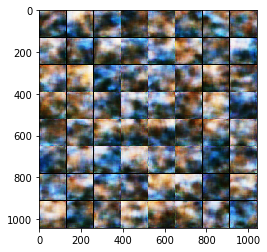

 20%|██        | 201/1000 [02:22<09:25,  1.41it/s]

201


 20%|██        | 202/1000 [02:25<09:36,  1.38it/s]

202


 20%|██        | 203/1000 [02:29<09:47,  1.36it/s]

203


 20%|██        | 204/1000 [02:33<09:57,  1.33it/s]

204


 20%|██        | 205/1000 [02:36<10:08,  1.31it/s]

205


 21%|██        | 206/1000 [02:40<10:18,  1.28it/s]

206


 21%|██        | 207/1000 [02:44<10:28,  1.26it/s]

207


 21%|██        | 208/1000 [02:47<10:38,  1.24it/s]

208


 21%|██        | 209/1000 [02:51<10:48,  1.22it/s]

209


 21%|██        | 210/1000 [02:55<10:58,  1.20it/s]

210


 21%|██        | 211/1000 [02:58<11:07,  1.18it/s]

211


 21%|██        | 212/1000 [03:02<11:17,  1.16it/s]

212


 21%|██▏       | 213/1000 [03:05<11:26,  1.15it/s]

213


 21%|██▏       | 214/1000 [03:09<11:36,  1.13it/s]

214


 22%|██▏       | 215/1000 [03:13<11:45,  1.11it/s]

215


 22%|██▏       | 216/1000 [03:16<11:54,  1.10it/s]

216


 22%|██▏       | 217/1000 [03:20<12:03,  1.08it/s]

217


 22%|██▏       | 218/1000 [03:23<12:11,  1.07it/s]

218


 22%|██▏       | 219/1000 [03:27<12:20,  1.06it/s]

219


 22%|██▏       | 220/1000 [03:31<12:28,  1.04it/s]

220


 22%|██▏       | 221/1000 [03:34<12:37,  1.03it/s]

221


 22%|██▏       | 222/1000 [03:38<12:45,  1.02it/s]

222


 22%|██▏       | 223/1000 [03:42<12:53,  1.00it/s]

223


 22%|██▏       | 224/1000 [03:45<13:01,  1.01s/it]

224


 22%|██▎       | 225/1000 [03:49<13:09,  1.02s/it]

225


 23%|██▎       | 226/1000 [03:52<13:17,  1.03s/it]

226


 23%|██▎       | 227/1000 [03:56<13:25,  1.04s/it]

227


 23%|██▎       | 228/1000 [03:59<13:32,  1.05s/it]

228


 23%|██▎       | 229/1000 [04:03<13:40,  1.06s/it]

229


 23%|██▎       | 230/1000 [04:07<13:47,  1.07s/it]

230


 23%|██▎       | 231/1000 [04:10<13:54,  1.09s/it]

231


 23%|██▎       | 232/1000 [04:14<14:02,  1.10s/it]

232


 23%|██▎       | 233/1000 [04:18<14:09,  1.11s/it]

233


 23%|██▎       | 234/1000 [04:21<14:16,  1.12s/it]

234


 24%|██▎       | 235/1000 [04:25<14:23,  1.13s/it]

235


 24%|██▎       | 236/1000 [04:28<14:30,  1.14s/it]

236


 24%|██▎       | 237/1000 [04:32<14:36,  1.15s/it]

237


 24%|██▍       | 238/1000 [04:35<14:43,  1.16s/it]

238


 24%|██▍       | 239/1000 [04:39<14:50,  1.17s/it]

239


 24%|██▍       | 240/1000 [04:43<14:56,  1.18s/it]

240


 24%|██▍       | 241/1000 [04:46<15:03,  1.19s/it]

241


 24%|██▍       | 242/1000 [04:50<15:09,  1.20s/it]

242


 24%|██▍       | 243/1000 [04:53<15:15,  1.21s/it]

243


 24%|██▍       | 244/1000 [04:57<15:22,  1.22s/it]

244


 24%|██▍       | 245/1000 [05:01<15:28,  1.23s/it]

245


 25%|██▍       | 246/1000 [05:04<15:34,  1.24s/it]

246


 25%|██▍       | 247/1000 [05:08<15:40,  1.25s/it]

247


 25%|██▍       | 248/1000 [05:12<15:46,  1.26s/it]

248


 25%|██▍       | 249/1000 [05:15<15:51,  1.27s/it]

249


 25%|██▌       | 250/1000 [05:19<15:57,  1.28s/it]

250


 25%|██▌       | 251/1000 [05:22<16:03,  1.29s/it]

251


 25%|██▌       | 252/1000 [05:26<16:08,  1.30s/it]

252


 25%|██▌       | 253/1000 [05:30<16:14,  1.30s/it]

253


 25%|██▌       | 254/1000 [05:33<16:20,  1.31s/it]

254


 26%|██▌       | 255/1000 [05:37<16:25,  1.32s/it]

255


 26%|██▌       | 256/1000 [05:40<16:30,  1.33s/it]

256


 26%|██▌       | 257/1000 [05:44<16:35,  1.34s/it]

257


 26%|██▌       | 258/1000 [05:48<16:41,  1.35s/it]

258


 26%|██▌       | 259/1000 [05:51<16:46,  1.36s/it]

259


 26%|██▌       | 260/1000 [05:55<16:51,  1.37s/it]

260


 26%|██▌       | 261/1000 [05:59<16:57,  1.38s/it]

261


 26%|██▌       | 262/1000 [06:03<17:02,  1.39s/it]

262


 26%|██▋       | 263/1000 [06:06<17:07,  1.39s/it]

263


 26%|██▋       | 264/1000 [06:10<17:13,  1.40s/it]

264


 26%|██▋       | 265/1000 [06:14<17:18,  1.41s/it]

265


 27%|██▋       | 266/1000 [06:18<17:23,  1.42s/it]

266


 27%|██▋       | 267/1000 [06:21<17:28,  1.43s/it]

267


 27%|██▋       | 268/1000 [06:25<17:33,  1.44s/it]

268


 27%|██▋       | 269/1000 [06:29<17:37,  1.45s/it]

269


 27%|██▋       | 270/1000 [06:33<17:42,  1.46s/it]

270


 27%|██▋       | 271/1000 [06:36<17:47,  1.46s/it]

271


 27%|██▋       | 272/1000 [06:40<17:52,  1.47s/it]

272


 27%|██▋       | 273/1000 [06:44<17:57,  1.48s/it]

273


 27%|██▋       | 274/1000 [06:48<18:01,  1.49s/it]

274


 28%|██▊       | 275/1000 [06:52<18:06,  1.50s/it]

275


 28%|██▊       | 276/1000 [06:55<18:11,  1.51s/it]

276


 28%|██▊       | 277/1000 [06:59<18:15,  1.52s/it]

277


 28%|██▊       | 278/1000 [07:03<18:20,  1.52s/it]

278


 28%|██▊       | 279/1000 [07:07<18:24,  1.53s/it]

279


 28%|██▊       | 280/1000 [07:11<18:28,  1.54s/it]

280


 28%|██▊       | 281/1000 [07:14<18:32,  1.55s/it]

281


 28%|██▊       | 282/1000 [07:18<18:36,  1.56s/it]

282


 28%|██▊       | 283/1000 [07:22<18:40,  1.56s/it]

283


 28%|██▊       | 284/1000 [07:26<18:44,  1.57s/it]

284


 28%|██▊       | 285/1000 [07:29<18:48,  1.58s/it]

285


 29%|██▊       | 286/1000 [07:33<18:52,  1.59s/it]

286


 29%|██▊       | 287/1000 [07:37<18:56,  1.59s/it]

287


 29%|██▉       | 288/1000 [07:41<18:59,  1.60s/it]

288


 29%|██▉       | 289/1000 [07:44<19:03,  1.61s/it]

289


 29%|██▉       | 290/1000 [07:48<19:07,  1.62s/it]

290


 29%|██▉       | 291/1000 [07:52<19:10,  1.62s/it]

291


 29%|██▉       | 292/1000 [07:56<19:14,  1.63s/it]

292


 29%|██▉       | 293/1000 [07:59<19:17,  1.64s/it]

293


 29%|██▉       | 294/1000 [08:03<19:21,  1.65s/it]

294


 30%|██▉       | 295/1000 [08:07<19:24,  1.65s/it]

295


 30%|██▉       | 296/1000 [08:11<19:28,  1.66s/it]

296


 30%|██▉       | 297/1000 [08:14<19:31,  1.67s/it]

297


 30%|██▉       | 298/1000 [08:18<19:34,  1.67s/it]

298


 30%|██▉       | 299/1000 [08:22<19:37,  1.68s/it]

299


 30%|███       | 300/1000 [08:26<19:40,  1.69s/it]

300


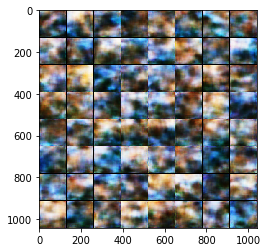

 30%|███       | 301/1000 [08:30<19:44,  1.69s/it]

301


 30%|███       | 302/1000 [08:33<19:47,  1.70s/it]

302


 30%|███       | 303/1000 [08:37<19:50,  1.71s/it]

303


 30%|███       | 304/1000 [08:41<19:53,  1.71s/it]

304


In [ ]:
gen_optim = torch.optim.Adam(g.parameters())


def optimize_generator():
    real_samples = next(iter(dataloader)).to(device)
    
    noise = torch.randn(batch_size, latent_size, device=device)
    fake_samples = g(noise, 5, 0).detach()

    loss = wgan_gp.gen_loss(real_samples, fake_samples, 0, 5)

    gen_optim.zero_grad()
    loss.backward()
    gen_optim.step()
    
    return loss.item()

eval_noise = torch.randn(batch_size, latent_size, device=device)

for i in tqdm(range(50 * 1000)):
    
    # For the first phase, just train using the anchors. This is faster.
    if i > 500:
        disc_loss = optimize_discriminator()
        gen_loss = optimize_generator()
    
    gen_loss_2 = optimize_generator_with_anchors()
    
    generated = g(eval_noise, 5, 0).detach()
    
    filename = 'samples/%d.png' % i
    create_grid(generated, filename)
    if i % 100 == 0:
        plt.imshow(cv2.imread(filename))
        plt.show()
    
    

In [ ]:
def interpolate_latent_vectors(vector_a, vector_b):
    vectors = torch.zeros(64, latent_size, device=device)
    for i in range(64):
        vectors[i] = vector_b * (i / 64.0) + vector_a * (1 - i / 64.0)
    generated = g(vectors, 5, 0)
    
    filename = 'samples/interpolation.png'
    create_grid(generated, filename)
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.imshow(cv2.imread(filename))
    plt.show()
        

interpolate_latent_vectors(anchor_latent_vectors[0], anchor_latent_vectors[8])